In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse


def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

# Load Data
with open('input.json', 'r') as inputFile:
    datas = json.load(inputFile)
    datas = {key:np.array(data) for key, data in datas.items()}
x1, y1 = datas['x1'], datas['y1']
x2, y2 = datas['x2'], datas['y2']
x3, y3 = datas['x3'], datas['y3']
data = [[x1, y1], [x2, y2], [x3, y3]]

In [2]:
x, y = data[0]
classes = np.unique(y)
num_classes = len(classes)
predictor = GMM(n_components=num_classes)
predictor.fit(x)

center = []
for c in classes:
    mask = (y == c)
    center.append(np.mean(x[mask], axis=0))
center = np.array(center)
center_predict = predictor.means_

distance = np.sqrt(np.sum((center[np.newaxis,...] - center_predict[:, np.newaxis, ...]) ** 2, axis= -1))
classes_mapping = np.argmin(distance, axis=-1)
center[classes_mapping]

array([[ 4.01189429,  1.73712037],
       [-2.51722518, 15.59154145],
       [-3.14057398,  5.76638109],
       [ 1.92668063,  8.67253275]])

In [70]:
# import matplotlib as mpl
from sklearn.mixture import GaussianMixture as GMM

COLORS = list(mcolors.TABLEAU_COLORS.values())

class GMM_predictor(object):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = x
        self.y = y
        self.classes = np.unique(self.y)
        self.num_classes = len(self.classes)
        # Set color for each class
        self.colors = dict()
        for c_idx, c in enumerate(self.classes):
            self.colors[c] = COLORS[c_idx]
        self.predictor = None # sklearn GMM object
    
    def _draw_distribution(self, ax, x:np.ndarray, y:np.ndarray, class_mapping:dict):

        for real_c in sorted(class_mapping.keys()):
            target = x[y == class_mapping[real_c], ...]
            x1 = target[:, 0]
            x2 = target[:, 1]
            ax.scatter(x1, x2, c=self.colors[real_c], s=15, label="Class {}".format(real_c))
            # Draw center
            center = np.mean(target, axis=0)
            ax.scatter(center[0], center[1], marker="D", c="orange", lw=1, edgecolors="black", s=16)
        ax.legend()

    def get_class_mapping(self):
        center = []
        for c in self.classes:
            mask = (self.y == c)
            center.append(np.mean(x[mask], axis=0))
        center = np.array(center)
        center_predict = self.predictor.means_
        distance = np.sqrt(np.sum((center[np.newaxis,...] - center_predict[:, np.newaxis, ...]) ** 2, axis= -1))
        mapping = np.argmin(distance, axis=-1)
        class_mapping = {c:i for i, c in enumerate(mapping)}

        return class_mapping
    def compute_acc(self):
        class_mapping = self.get_class_mapping()
        predict_y = self.predictor.predict(self.x)
        mapping_pred_y = np.zeros((self.y.shape))
        for real_c, c in class_mapping.items():
            mask = (predict_y == c)
            mapping_pred_y[mask] = real_c
        acc = (mapping_pred_y == self.y).sum() / len(self.y)
        return acc
    def draw_figure(self):
        fig = plt.figure(figsize=(12,5), tight_layout=True)
        fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
        # Draw origin distribution
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_xlabel('$x_1$')
        ax1.set_ylabel('$x_2$')
        ax1.set_title("Origin distribution")
        class_mapping = {c:c for c in self.classes}
        self._draw_distribution(ax1, self.x, self.y, class_mapping)
        
        # Draw distribution for prediction
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_xlabel('$x_1$')
        ax2.set_ylabel('$x_2$')
        ax2.set_title("GMM prediction distribution")
        predict_y = self.predictor.predict(self.x)
        class_mapping = self.get_class_mapping()
        self._draw_distribution(ax2, self.x, predict_y, class_mapping)
        
        # Draw Correct and Wrong
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title("Correct and Wrong Points")
        ax3.set_xlabel('$x_1$')
        ax3.set_ylabel('$x_2$')
        mapping_pred_y = np.zeros((self.y.shape))
        for real_c, c in class_mapping.items():
            mask = (predict_y == c)
            mapping_pred_y[mask] = real_c
        acc = (mapping_pred_y == self.y).sum() / len(self.y)
        correct_mask = (mapping_pred_y == self.y)
        target = x[correct_mask, ...]
        ax3.scatter(target[:, 0], target[:, 1], c='g', marker='x',label="Correct Points")
        target = x[~correct_mask, ...]
        ax3.scatter(target[:, 0], target[:, 1], c='r', marker='x',label="Wrong Points")
        ax3.legend()
        x1_min = min(x[:,0])
        x2_min = min(x[:,1])
        ax3.text(x1_min, x2_min, 'Accuracy = {:.3f}'.format(acc))
       
    def set_gmm(self, **args):
        self.gmm_setting = args
        self.predictor = GMM(n_components=self.num_classes, **args)
        self.predictor.fit(self.x)

x, y = data[1]

gmm = GMM_predictor(x, y)
exp_setting = {'covariance_type': ['full', 'tied', 'diag', 'spherical'],
                'init_params':['kmeans', 'k-means++', 'random', 'random_from_data'],
                'tol':[1e-1, 1e-2, 1e-3],
                'max_iter':[50, 100]}

exp_order = ['covariance_type', 'init_params', 'tol', 'max_iter']
def gen_exp(cur_i:int, indices:list):
    cur_setting = exp_order[cur_i]
    for i in range(len(exp_setting[cur_setting])):
        if cur_i == 0:
            indices = []
        if cur_i == len(exp_setting) - 1: 
            yield indices + [i]
        else:
            yield from gen_exp(cur_i + 1, indices + [i])

for exp in gen_exp(0, None):
    setting = dict()
    for arg, i in zip(exp_order, exp):
        setting[arg] = exp_setting[arg][i]
    print(setting)
    gmm.set_gmm(**setting)
    acc = gmm.compute_acc()
    print(acc)
# result = dict()
# while True:
#     # for i in exp_index

#     cur_i = 0
#     exp_index[cur_i] += 1
#     if exp_index == final_exp:
#         break
#     while exp_index[cur_i] == final_exp[cur_i] + 1:
#         exp_index[cur_i] = 0
#         cur_i = (cur_i + 1) % len(exp_setting)
#         exp_index[cur_i] += 1
#     gmm.set_gmm()
#     acc = gmm.compute_acc()
#     print(acc)
    


{'covariance_type': 'full', 'init_params': 'kmeans', 'tol': 0.1, 'max_iter': 50}
0.873
{'covariance_type': 'full', 'init_params': 'kmeans', 'tol': 0.1, 'max_iter': 100}
0.996
{'covariance_type': 'full', 'init_params': 'kmeans', 'tol': 0.01, 'max_iter': 50}
0.996
{'covariance_type': 'full', 'init_params': 'kmeans', 'tol': 0.01, 'max_iter': 100}
0.996
{'covariance_type': 'full', 'init_params': 'kmeans', 'tol': 0.001, 'max_iter': 50}
0.996
{'covariance_type': 'full', 'init_params': 'kmeans', 'tol': 0.001, 'max_iter': 100}
0.996
{'covariance_type': 'full', 'init_params': 'k-means++', 'tol': 0.1, 'max_iter': 50}


ValueError: Unimplemented initialization method 'k-means++'

In [71]:
import sklearn
sklearn.__version__

'1.0.2'

In [64]:
[4, 4, 4, 3] == [4, 4, 4, 3]

True

Text(0.5, 1.0, 'Class')

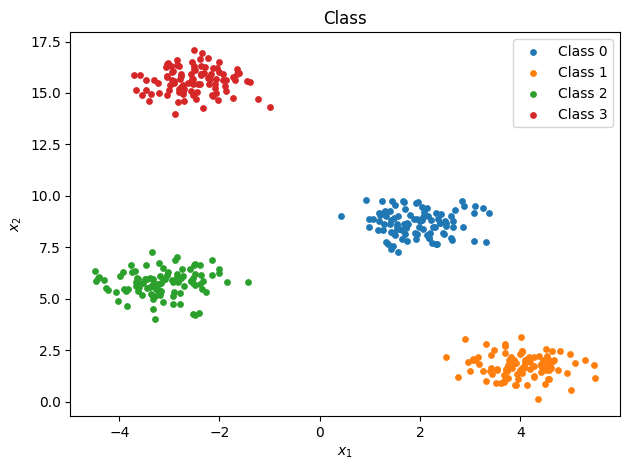

In [20]:
import matplotlib.pyplot as plt

plt.figure(tight_layout=True)
axs = plt.axes()
axs.set_xlabel('$x_1$')
axs.set_ylabel('$x_2$')

classes = np.unique(y)
for c_idx, c in enumerate(classes):
    target = x[y == c,:]
    x1 = target[:, 0]
    x2 = target[:, 1]
    axs.scatter(x1, x2, cmap=gmm.colors[c_idx], s=15, label="Class {}".format(c))
axs.legend()
axs.set_title("Class")

In [ ]:
predict_y = gmm.predictor.predict(x)
gmm.find_center_mapping()

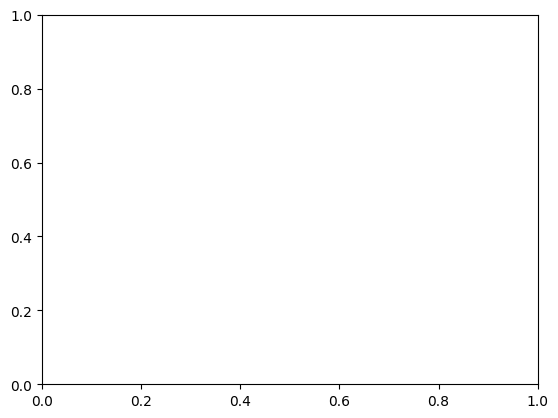

In [15]:
fig = plt.figure()
ax = plt.gca()


In [ ]:
212
3
